In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.lines import Line2D
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-white')  # 'seaborn-ticks'
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import dateutil
import seaborn as sns

In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

order_cols = rn.columns.to_list() + fn.columns.to_list() + \
                ri.columns.to_list() + fi.columns.to_list() + \
                rd.columns.to_list() + fd.columns.to_list()

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [3]:
# data = pd.read_csv(r'..\data\processed\metab_lipid_merged_df.csv', index_col=0).T
data[data_cols]

,1076_10_FBG,1062_8_FBG,1093_9_FBG,1060_8_RBG,1091_10_FBG,1092_9_RBG,1093_10_RBG,1082_10_FBG,1060_9_RBG,1101_9_FBG,...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
i,,,,,,,,,,,,,,,,,,,,,
l_0,20.405355,23.313111,23.218699,24.012349,24.302356,23.901455,23.883301,23.387975,24.421692,23.463756,...,22.462249,23.360916,22.399150,23.163419,22.737840,22.116533,23.352451,23.527438,23.858693,23.617549
l_1,21.533648,24.586227,24.375151,25.685664,25.422294,24.936916,24.779941,24.696276,25.054941,24.934805,...,24.663849,23.700392,23.382317,24.385568,23.789670,22.248759,22.513249,24.558075,24.818525,24.575904
l_2,20.665848,23.731244,23.038733,24.916555,24.042666,24.162971,23.627979,24.085858,23.169508,24.010849,...,23.452626,22.549975,23.249352,23.680978,23.989589,23.527507,24.002570,23.886203,24.069137,23.455789
l_3,24.400930,26.811664,26.708762,25.977120,27.313654,27.337061,27.415597,27.230430,27.598719,27.126653,...,27.210668,26.194952,26.911119,26.805997,26.145097,26.638404,27.217392,26.970428,27.175265,26.482705
l_4,19.378685,22.709669,21.722467,23.985839,22.321161,23.184906,22.795191,22.878785,22.397716,22.703282,...,22.602208,21.905509,22.226570,22.485669,22.208159,22.236114,23.151359,22.823820,21.750593,22.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,24.882649,24.605962,25.488336,24.568105,24.949127,25.119634,25.008021,24.852314,25.064357,24.826840,...,24.942889,24.895636,24.931289,25.067714,25.395219,24.788981,24.894367,25.168366,25.050323,24.771208
m_213,20.930852,21.303302,19.581065,23.318774,19.437282,23.268904,23.345351,22.052052,17.810755,19.078979,...,20.484062,23.047250,23.625874,20.663426,20.698623,20.921984,24.008593,22.538237,21.117720,18.221881
m_24,27.101820,27.465801,26.936184,27.795283,27.044044,27.561589,27.863524,27.438797,26.430616,26.924145,...,27.236489,27.782425,27.946315,27.362929,27.223422,27.298238,28.052793,27.463850,27.304277,26.282341


In [9]:
# feature_indexes = {i: int(col) for i, col in enumerate(df.columns)}
# raw_data = df.filter(regex='HILIC_T', axis=0)

groups = fg[['combined_col_name', 'animal', 'week', 'bg_type', 'gluc_tol']]
groups = groups.set_index('combined_col_name')
# display(groups)

raw_data = pd.merge(data.T, groups, how='inner',
                    left_on=data.T.index, right_on=groups.index).set_index('key_0')
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])  # Scaling is essential for PCA
pca_data = pipeline.fit_transform(raw_data.filter(regex='m_|l_'))  # 2**raw gives the original untransformed data ###
# print(pca_data.shape)
# display(pca_data)
pca_object = pipeline.steps[1][1]
columns = ['pc' + str(x) for x in range(1, pca_data.shape[1] + 1)]
# print(columns)
pca_data = pd.DataFrame(pca_data, columns=columns)
# display(pca_data)
pca_data.index = raw_data.index
# display(pca_data)
pca_data = pd.concat([pca_data, raw_data[['animal', 'week', 'bg_type', 'gluc_tol']]], axis=1)
# display(pca_data)


## Loadings:

In [16]:
loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_))
# loadings = loadings.sort_values(0, ascending=False)
# plt.bar(np.arange(loadings.shape[1]), loadings[:, 0])

loadings.set_index(data.index).to_csv(r'..\data\processed\PCA_loadings.csv')

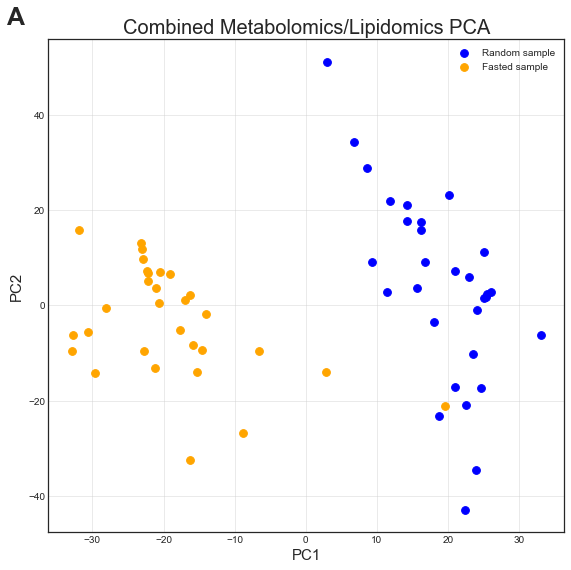

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('Combined Metabolomics/Lipidomics PCA', fontsize=20)

targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
target_colors = ['blue', 'orange']
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for target, color in zip(targets, target_colors):
    points = pca_data.loc[pca_data['bg_type'] == target]
    ax.scatter(points['pc1'], points['pc2'],
               c=color, cmap='viridis', s=60)
ax.legend(['Random sample', 'Fasted sample'])
ax.grid(alpha=0.5)

ax.text(-0.08, 1.03, "A", transform=ax.transAxes, fontsize=25, weight='bold')

plt.tight_layout()

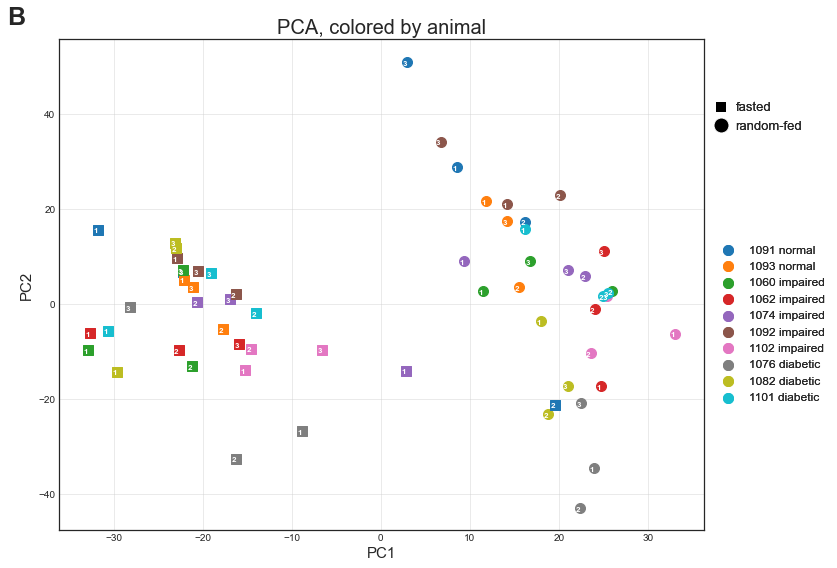

In [16]:
fig = plt.figure(figsize = (8,8))
fig.set_size_inches(10, 8)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal', fontsize = 20)
targets = ['RBG', 'FBG']
weeks = [8, 9, 10]
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []

for target, marker in zip(targets, markers):
    for label, color in zip(animals_used, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & \
                                  (pca_data['animal'] == label)]
#             print(scatter_points)
        handle = ax.scatter(scatter_points['pc1'],
                            scatter_points['pc2'],
                            c = color,
#                             cmap='viridis',
                            marker=marker,
                            s = (110 if marker == 's' else 100))

#         Annotate the plot with number for week 8, 9, 10 (convert to 1, 2, 3 for ease of reading)
        for index, row in scatter_points.iterrows():
            week = row['week'] - 7  # Minus 7 to go from week 8->1, 9->2, 10->3
            ax.annotate(str(week), xy=(row['pc1']-0.5, row['pc2']-0.7), 
                        fontsize=8, color='white', weight='bold')

        # define the text label for the data handle for the legend:
        gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == label]['glucose_tolerance'].values[0]
        handle.set_label(str(label) + ' ' + gluc_tol)
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
# legend = ax.legend(handles, labels, loc=(1.01, 0.23))

legend = ax.legend(handles[:10], labels[:10], loc=(1.01, 0.25), fontsize=12)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))

legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                             Line2D([0], [0], marker='o', color='white', label='random-fed', 
                                    markerfacecolor='black', markersize=15)], 
                    loc=(1.01, 0.8), 
                    fontsize=13, 
                    handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
ax.add_artist(legend)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')])

ax.text(-0.08, 1.03, "B", transform=ax.transAxes, fontsize=25, weight='bold')
# ax.text(1.072, 0.87, "Animal, feeding, glucose tolerance", transform=ax.transAxes, fontsize=9)

plt.tight_layout()

In [17]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

NameError: name 'animal_to_tolerance_dict' is not defined

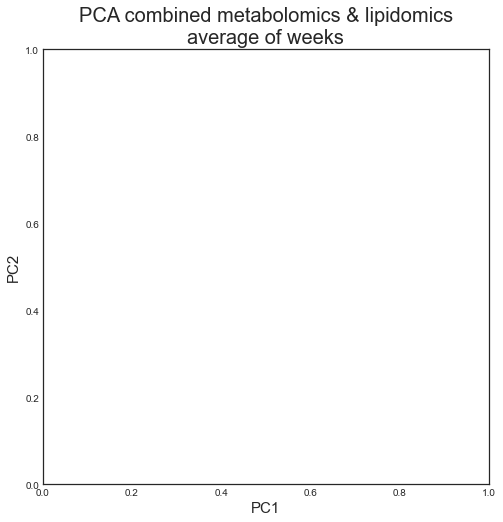

In [11]:
pc_to_plot_x = 1
pc_to_plot_y = 2

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc_to_plot_x), fontsize = 15)
ax.set_ylabel('PC' + str(pc_to_plot_y), fontsize = 15)
ax.set_title('PCA combined metabolomics & lipidomics\naverage of weeks', fontsize = 20)

markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]
handles = []
for rat_label, color in zip(animals_used, colors):
    for bg_type, marker in zip(['RBG', 'FBG'], markers):
        tolerance_type = animal_to_tolerance_dict[rat_label]
        edge_color = None
        if tolerance_type == 'diabetic':
            edge_color = 'lightgray'
        elif tolerance_type == 'impaired':
            edge_color = 'darkgray'
        else: 
            edge_color = 'black'

        scatter_points = pca_data[(pca_data['gluc_tol'] == tolerance_type) & \
                                  (pca_data['animal'] == (rat_label)) & \
                                  (pca_data['bg_type'] == bg_type)].mean(axis=0)
        handle = ax.scatter(scatter_points['pc' + str(pc_to_plot_x)],
                            scatter_points['pc' + str(pc_to_plot_y)],
                            c = color,
                            marker=marker,
#                             edgecolors=edge_color,
#                             linewidths=3,              # linewidths is stroke size of marker outline
                            s = (250 if marker == 's' else 220),
                            )
#         # Annotate the plot with letter for Diabetic, Normal, Impaired
#         ax.annotate(tolerance_type[0].upper(), 
#                     xy=(scatter_points['pc1']-0.5, scatter_points['pc2']-0.7), 
#                     fontsize=20,
#                     color='black')
        # define the text label for the data handle for the legend:
#         gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == rat_label]['glucose_tolerance'].values[0]
        handle.set_label(str(rat_label) + ' ' + tolerance_type )
        handles.append(handle)
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])
handles, labels = ax.get_legend_handles_labels()
# print(handles, labels)
legend = ax.legend(handles[::2], labels[::2], loc=(0.995, 0.16), fontsize=14)
# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
legend2 = ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='fasted', ),
                   Line2D([0], [0], marker='o', color='white', label='random-fed', 
                          markerfacecolor='black', markersize=15)], loc=(1.01, 0.7), fontsize=15, handlelength=0.7)
ax.add_artist(legend)
ax.add_artist(legend2)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')], loc=(1.01, 0.98))
ax.text(-0.08, 1.03, "D", transform=ax.transAxes, fontsize=25, weight='bold')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(f'PC{pc_to_plot_x}', fontsize=15)
plt.ylabel(f'PC{pc_to_plot_y}', fontsize=15)

# plt.tight_layout()
# plt.savefig(r'..\reports\figures\3-5-1\multiomics_PCA_week_average.png', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\3-5-1\multiomics_PCA_week_average.svg', bbox_inches='tight')